In [1]:
import glob
import os
from datetime import datetime, timedelta, time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import learning_lidar.preprocessing.preprocessing_utils as prep_utils
from learning_lidar.utils import xr_utils, global_settings as gs
import learning_lidar.utils.vis_utils as vis_utils
import learning_lidar.generation.generation_utils as gen_utils
%matplotlib inline
from IPython.display import display

vis_utils.set_visualization_settings()
SAVE_FIG = True
VIS_LIDAR_DS = True

In [2]:
def get_TROPOS_raw_nc_timestamp(nc_path):
	format_filename = r"(.*)_(.*)_TROPOS_(.*)_01.nc"
	format_times = ["%Y_%m_%d","%a", "%H_%M"]
	date_time = prep_utils.extract_date_time(nc_path,format_filename, format_times)
	timestamp = datetime.combine(date = date_time[0].date(),time=date_time[2].time())
	return timestamp


# Exploring dynamic range of the signal
#### This notebook compares the range corrected signal retrieved from two sources:
#### 1. The raw lidar measurements as : $(p-p_{bg})\cdot r^2 $
#### 2. The post analysed signal by TROPOS as: $att\_bsc \cdot CL $
> Where:
> 1. $att\_bsc = \beta \cdot \exp(-2\tau)$
> $(p - p_{bg})\cdot r^2 \cdot  = att\_bsc\cdot CL$
> 2. The values $att\_bsc$ and $CL$ are found in the files: `*att_bsc.nc`
> 3. The lidar measurements are found in the files: `measure_datetime.strftime(%Y_%m_%d_%a_TROPOS_%H_%m_01.nc)`,
> where `measure_datetime` is the start measure time of the file, e.g., 2017_09_12_Tue_TROPOS_18_00_01.nc`


In [3]:
print('load station and setting date')
'''set day'''
day_date = datetime(2017,9,13)
print(day_date)
'''set station'''
station = gs.Station('Haifa')
#print(station)
#station.lidar_dataset

load station and setting date
2017-09-13 00:00:00


In [4]:
## Load daily dataset
# TODO: fix folder location of original data from TROPOS
file_type = 'all' # options : 'all', | 'range_corr' | 'attbc'
dsource = 'preprocess'# 'generation'# Data source options: 'preprocess' (for lidar raw measurements) | 'generation' (for lidar generated measurements)
LOAD_LIDAR_DS = True
if LOAD_LIDAR_DS:
	if dsource=='preprocess':
		lidar_ncpaths= xr_utils.get_prep_dataset_paths ( station , day_date ,
													 data_source = 'lidar',
													 file_type = file_type)
	elif dsource=='generation':
		lidar_ncpaths = gen_utils.get_daily_ds_path(station, day_date, type_='lidar')
	print(lidar_ncpaths)

if LOAD_LIDAR_DS:
	print( 'Load range corr in all channels')
	netcdf = lidar_ncpaths if type(lidar_ncpaths) is str else lidar_ncpaths[-1]
	ds_lidar =  xr_utils.load_dataset(netcdf)
	display(ds_lidar)
	wavelengths = ds_lidar.Wavelength.values.tolist()
if LOAD_LIDAR_DS and file_type=='range_corr':
	print( 'Load range corr per channel')
	netcdf = lidar_ncpaths[0]
	ds_load_pr2_chan = xr_utils.load_dataset(netcdf)
	display(ds_load_pr2_chan)
else :
	profile_type = 'range_corr'

['D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_13_Haifa_lidar.nc']
Load range corr in all channels


<xarray.Dataset>
Dimensions:     (Time: 2880, Height: 3000, Wavelength: 3)
Coordinates:
  * Time        (Time) datetime64[ns] 2017-09-13 ... 2017-09-13T23:59:30
  * Height      (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Wavelength  (Wavelength) int32 355 532 1064
Data variables:
    p           (Wavelength, Height, Time) float32 13.0 9.0 16.0 ... 0.0 0.0 0.0
    range_corr  (Wavelength, Height, Time) float32 0.08062 0.05581 ... 0.0 0.0
    p_bg        (Wavelength, Height, Time) float32 0.0 0.0 0.0 ... 0.0 0.004
    date        datetime64[ns] 2017-09-13
Attributes:
    location:     Haifa
    info:         Daily raw lidar measurement from TROPOS.
    source_file:  preprocessing_utils.py

visualizing without range_plot:


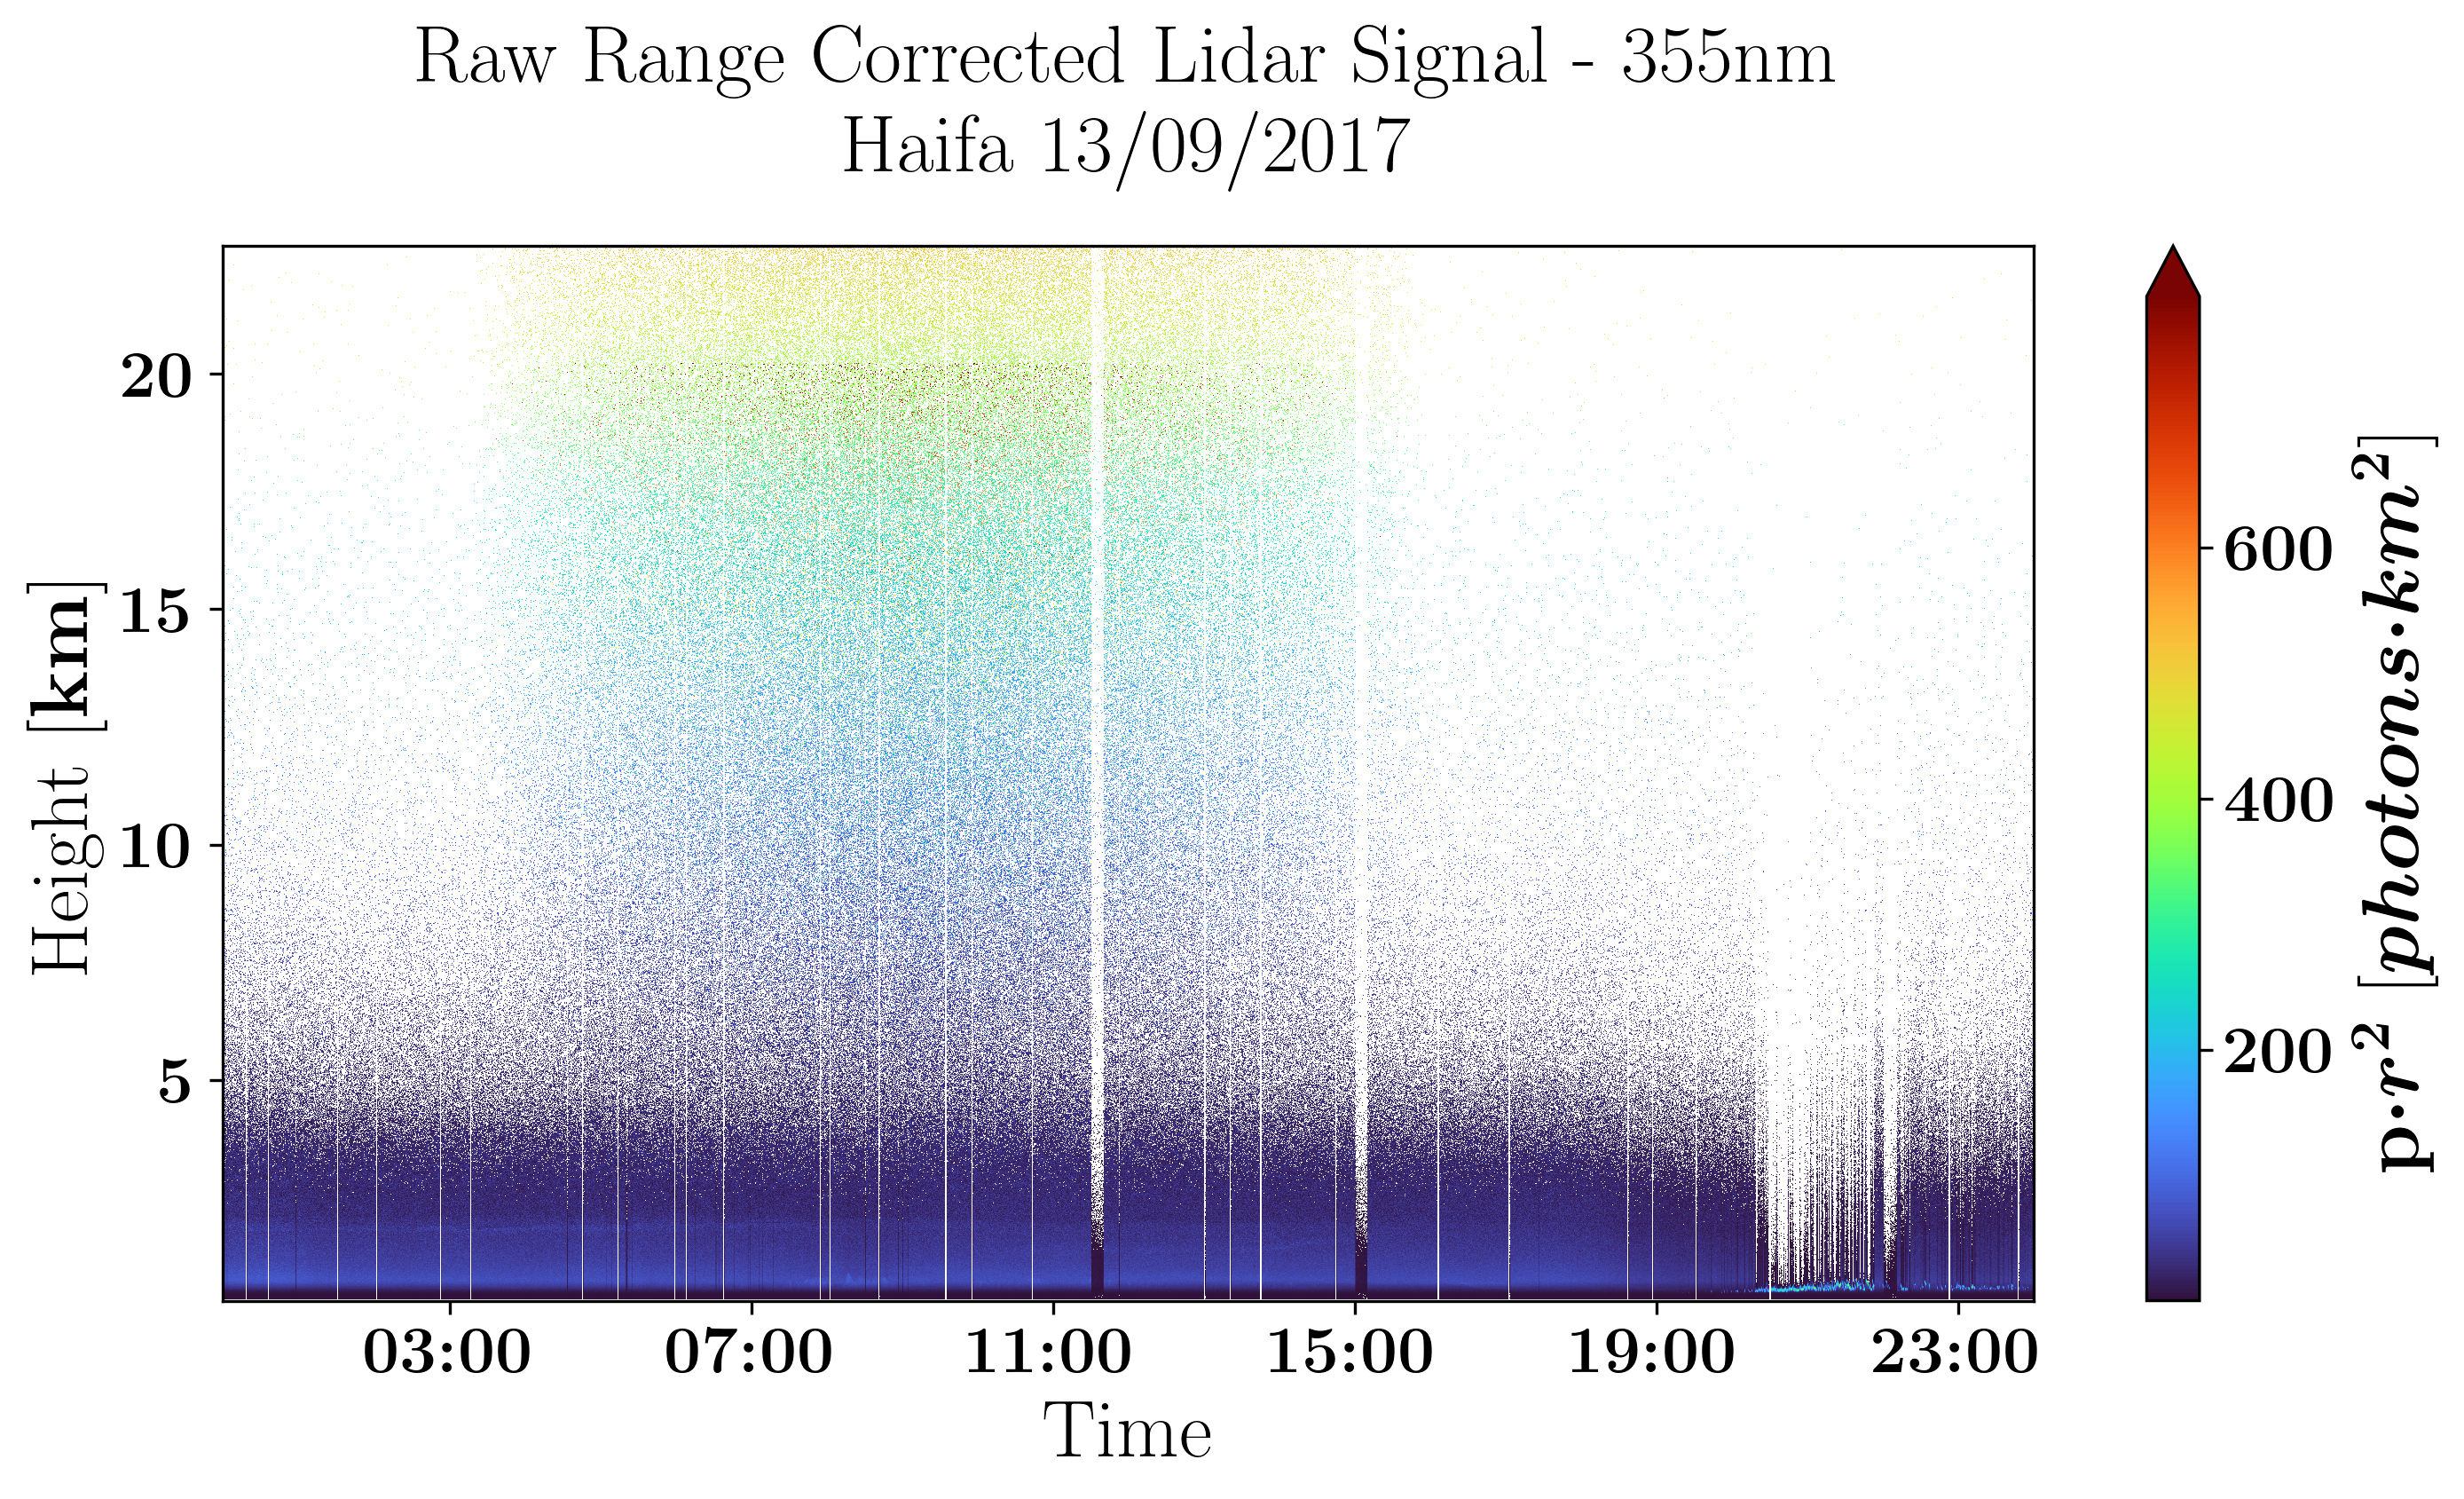

c:\users\addalin\dropbox\lidar\lidar_learning\figures\Raw Range Corrected Lidar Signal - 355nm Haifa 13_09_2017.png


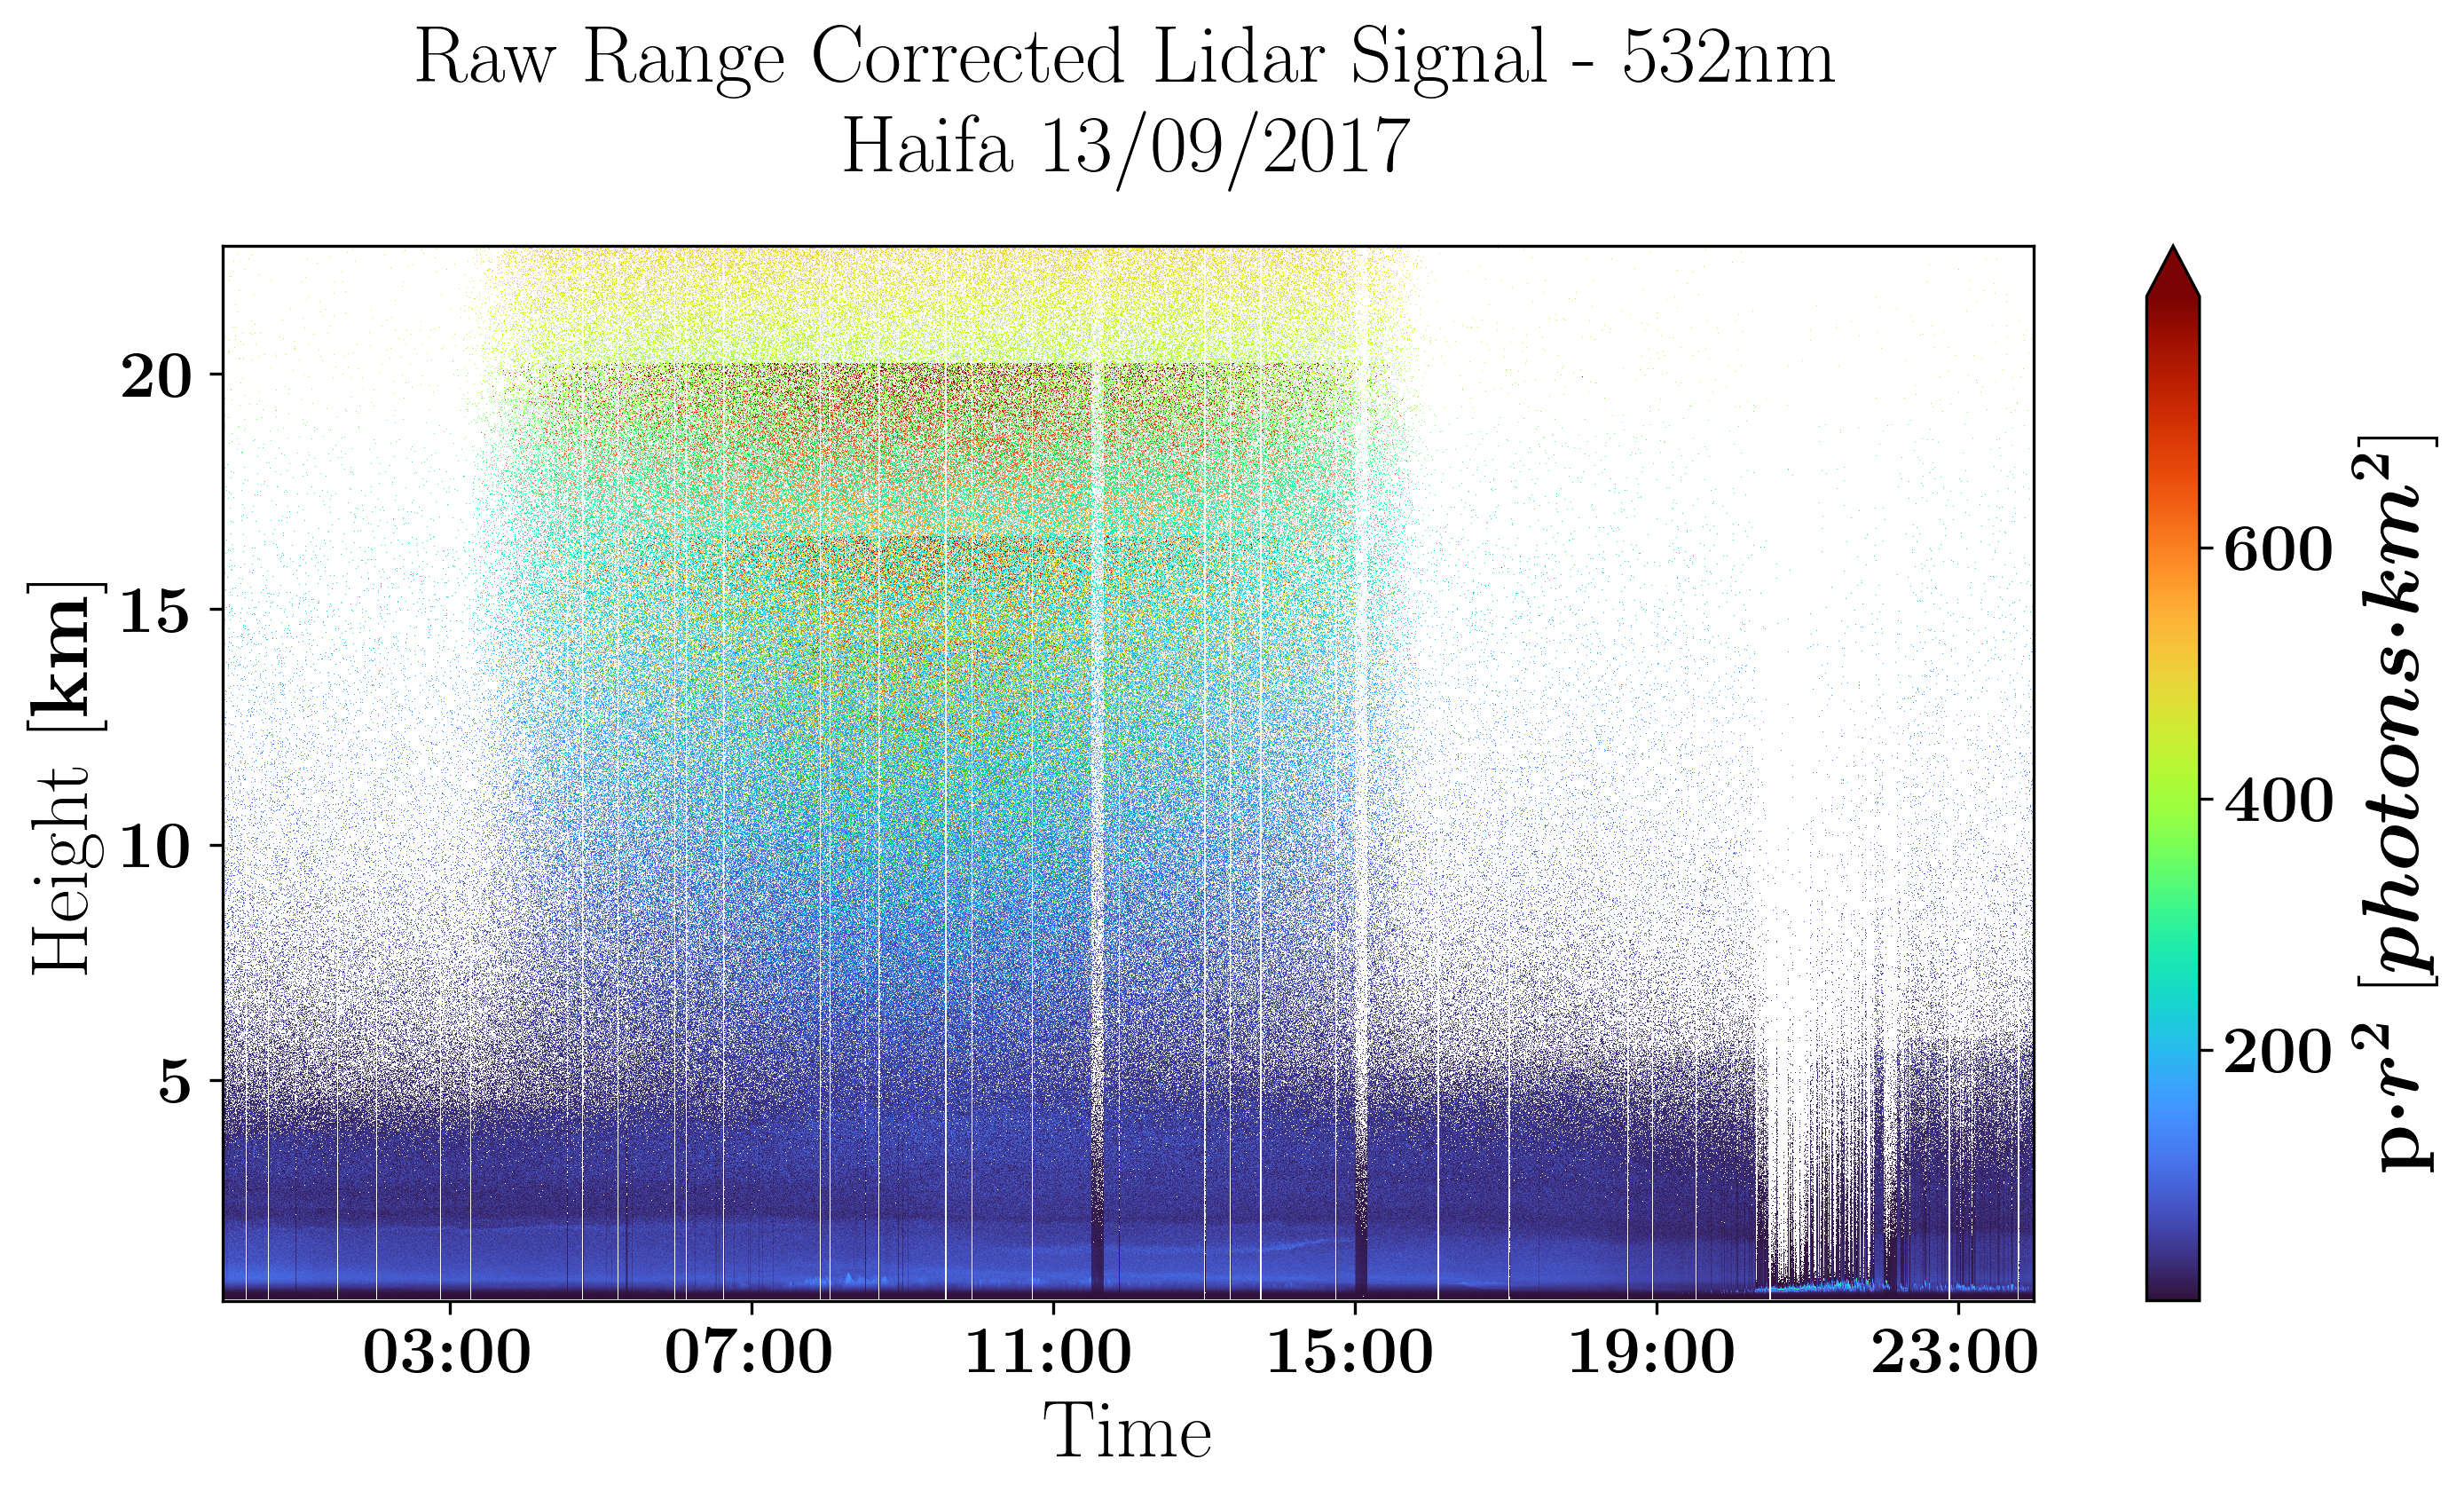

c:\users\addalin\dropbox\lidar\lidar_learning\figures\Raw Range Corrected Lidar Signal - 532nm Haifa 13_09_2017.png


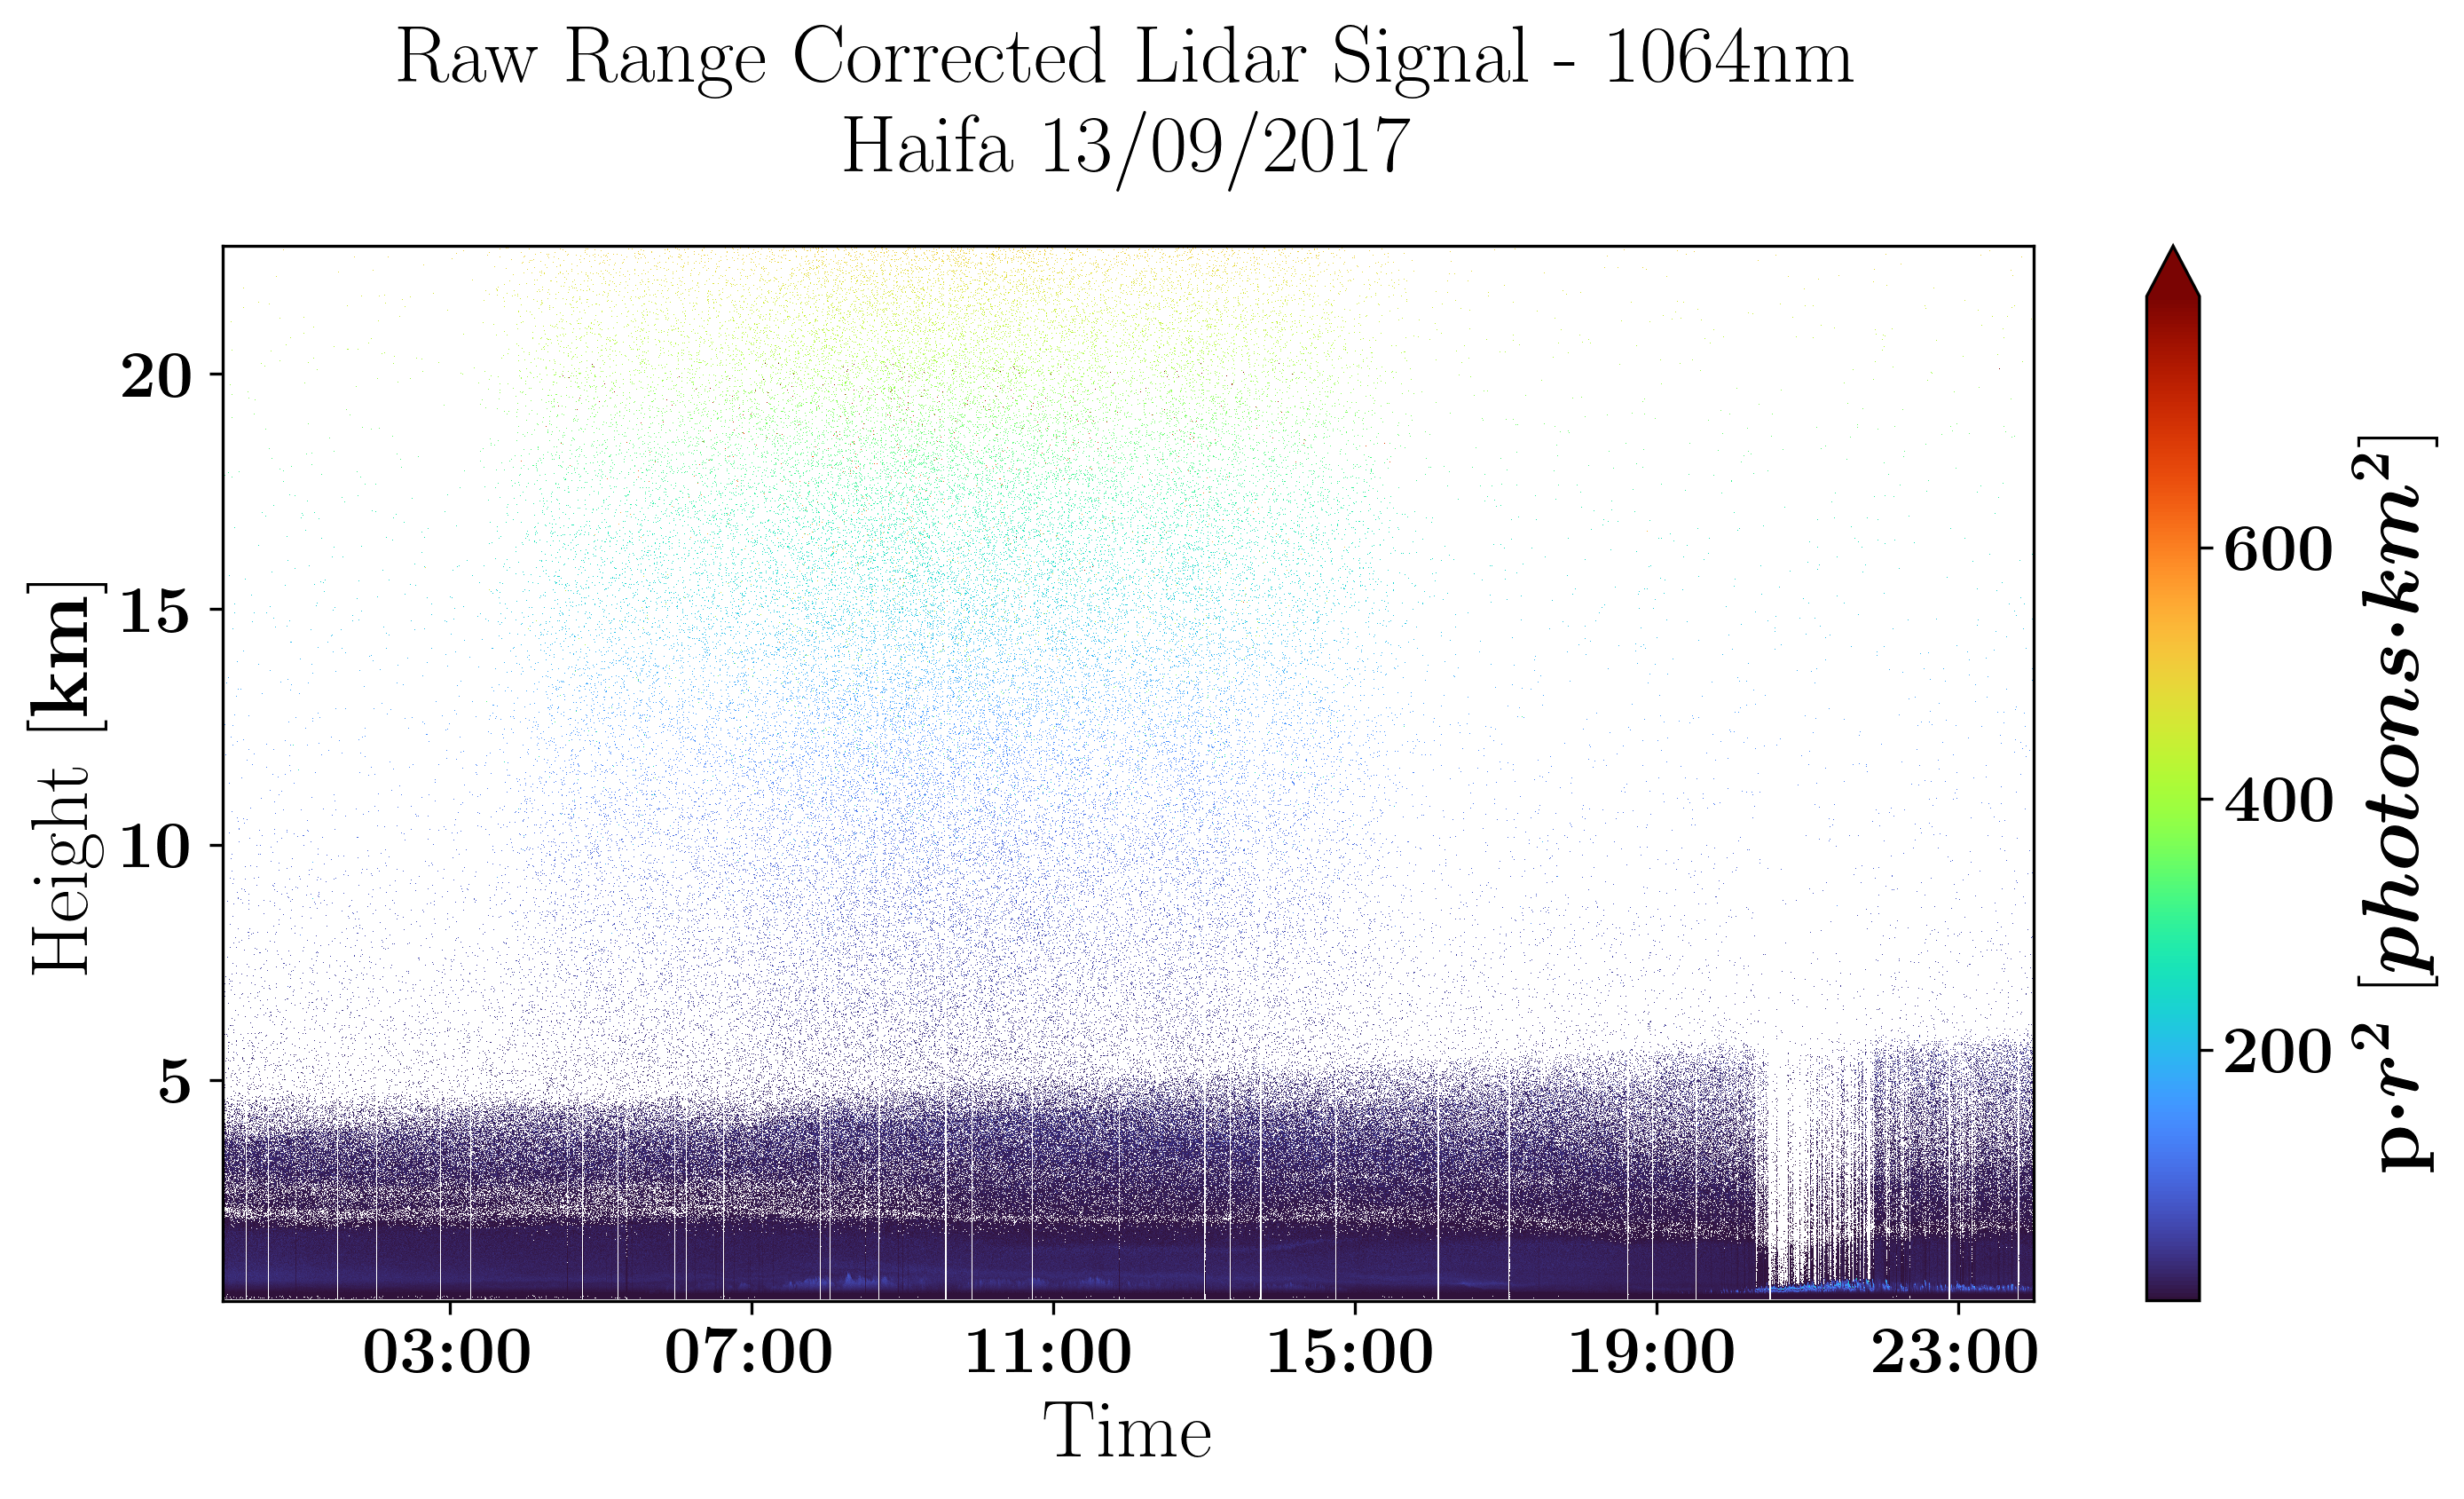

c:\users\addalin\dropbox\lidar\lidar_learning\figures\Raw Range Corrected Lidar Signal - 1064nm Haifa 13_09_2017.png


In [5]:
if VIS_LIDAR_DS:
	print('visualizing without range_plot:')
	for wav in wavelengths:
		USE_RANGE = None
		g,fig_path = vis_utils.visualize_ds_profile_chan(ds_lidar, wav,minv=0,maxv=800,
                                                          profile_type = profile_type,
                                                          SAVE_FIG= SAVE_FIG)
		if fig_path is not None:
			print(fig_path)


In [6]:
# if VIS_LIDAR_DS:
# 	print("Visualizing within the 'range_plot' bounding values:")
# 	for wav in wavelengths:
# 		g = vis_utils.visualize_ds_profile_chan(ds_lidar, wav,
# 		                                   profile_type = profile_type,
# 										     USE_RANGE='MID', SAVE_FIG= SAVE_FIG)

In [7]:
# if VIS_LIDAR_DS:
# 	print("Visualizing below the 'range_plot':")
# 	for wav in wavelengths:
# 		g = vis_utils.visualize_ds_profile_chan(ds_lidar, wav,
#                                    profile_type = profile_type,USE_RANGE='LOW', SAVE_FIG= SAVE_FIG)

In [8]:
# if VIS_LIDAR_DS:
# 	print("Visualizing above the 'range_plot':")
# 	for wav in wavelengths:
# 		g = vis_utils.visualize_ds_profile_chan(ds_lidar, wav,
#                                    profile_type = profile_type,USE_RANGE='HIGH', SAVE_FIG= SAVE_FIG)

In [5]:
#import learning_lidar.preprocessing.preprocessing_utils as prep_utils
r2_ds = prep_utils.calc_r2_da(station, day_date)
p_tilde = xr.apply_ufunc(lambda x,y: x-y,ds_lidar.p,ds_lidar.p_bg,keep_attrs=True).rename('pBGC')
p_tilde.attrs['info'] = ds_lidar.p.attrs['info']+' Background Corrected'
RCS_tilde = xr.apply_ufunc(lambda x,y: x*y,p_tilde,r2_ds,keep_attrs=True).rename('pRBGC')
RCS_tilde.attrs = {'info': ds_lidar.p.attrs['info']+' Background and Range Corrected',
				   'long_name': r'$\rm p$' + r'$\cdot r^2$', 'name': 'range_corr',
			  	   'units': r'$\rm$' + r'$photons$' + r'$\cdot km^2$',
			  	   'location': station.location, }

ds_lidar= ds_lidar.assign(pRBGC = RCS_tilde, pBGC = p_tilde )

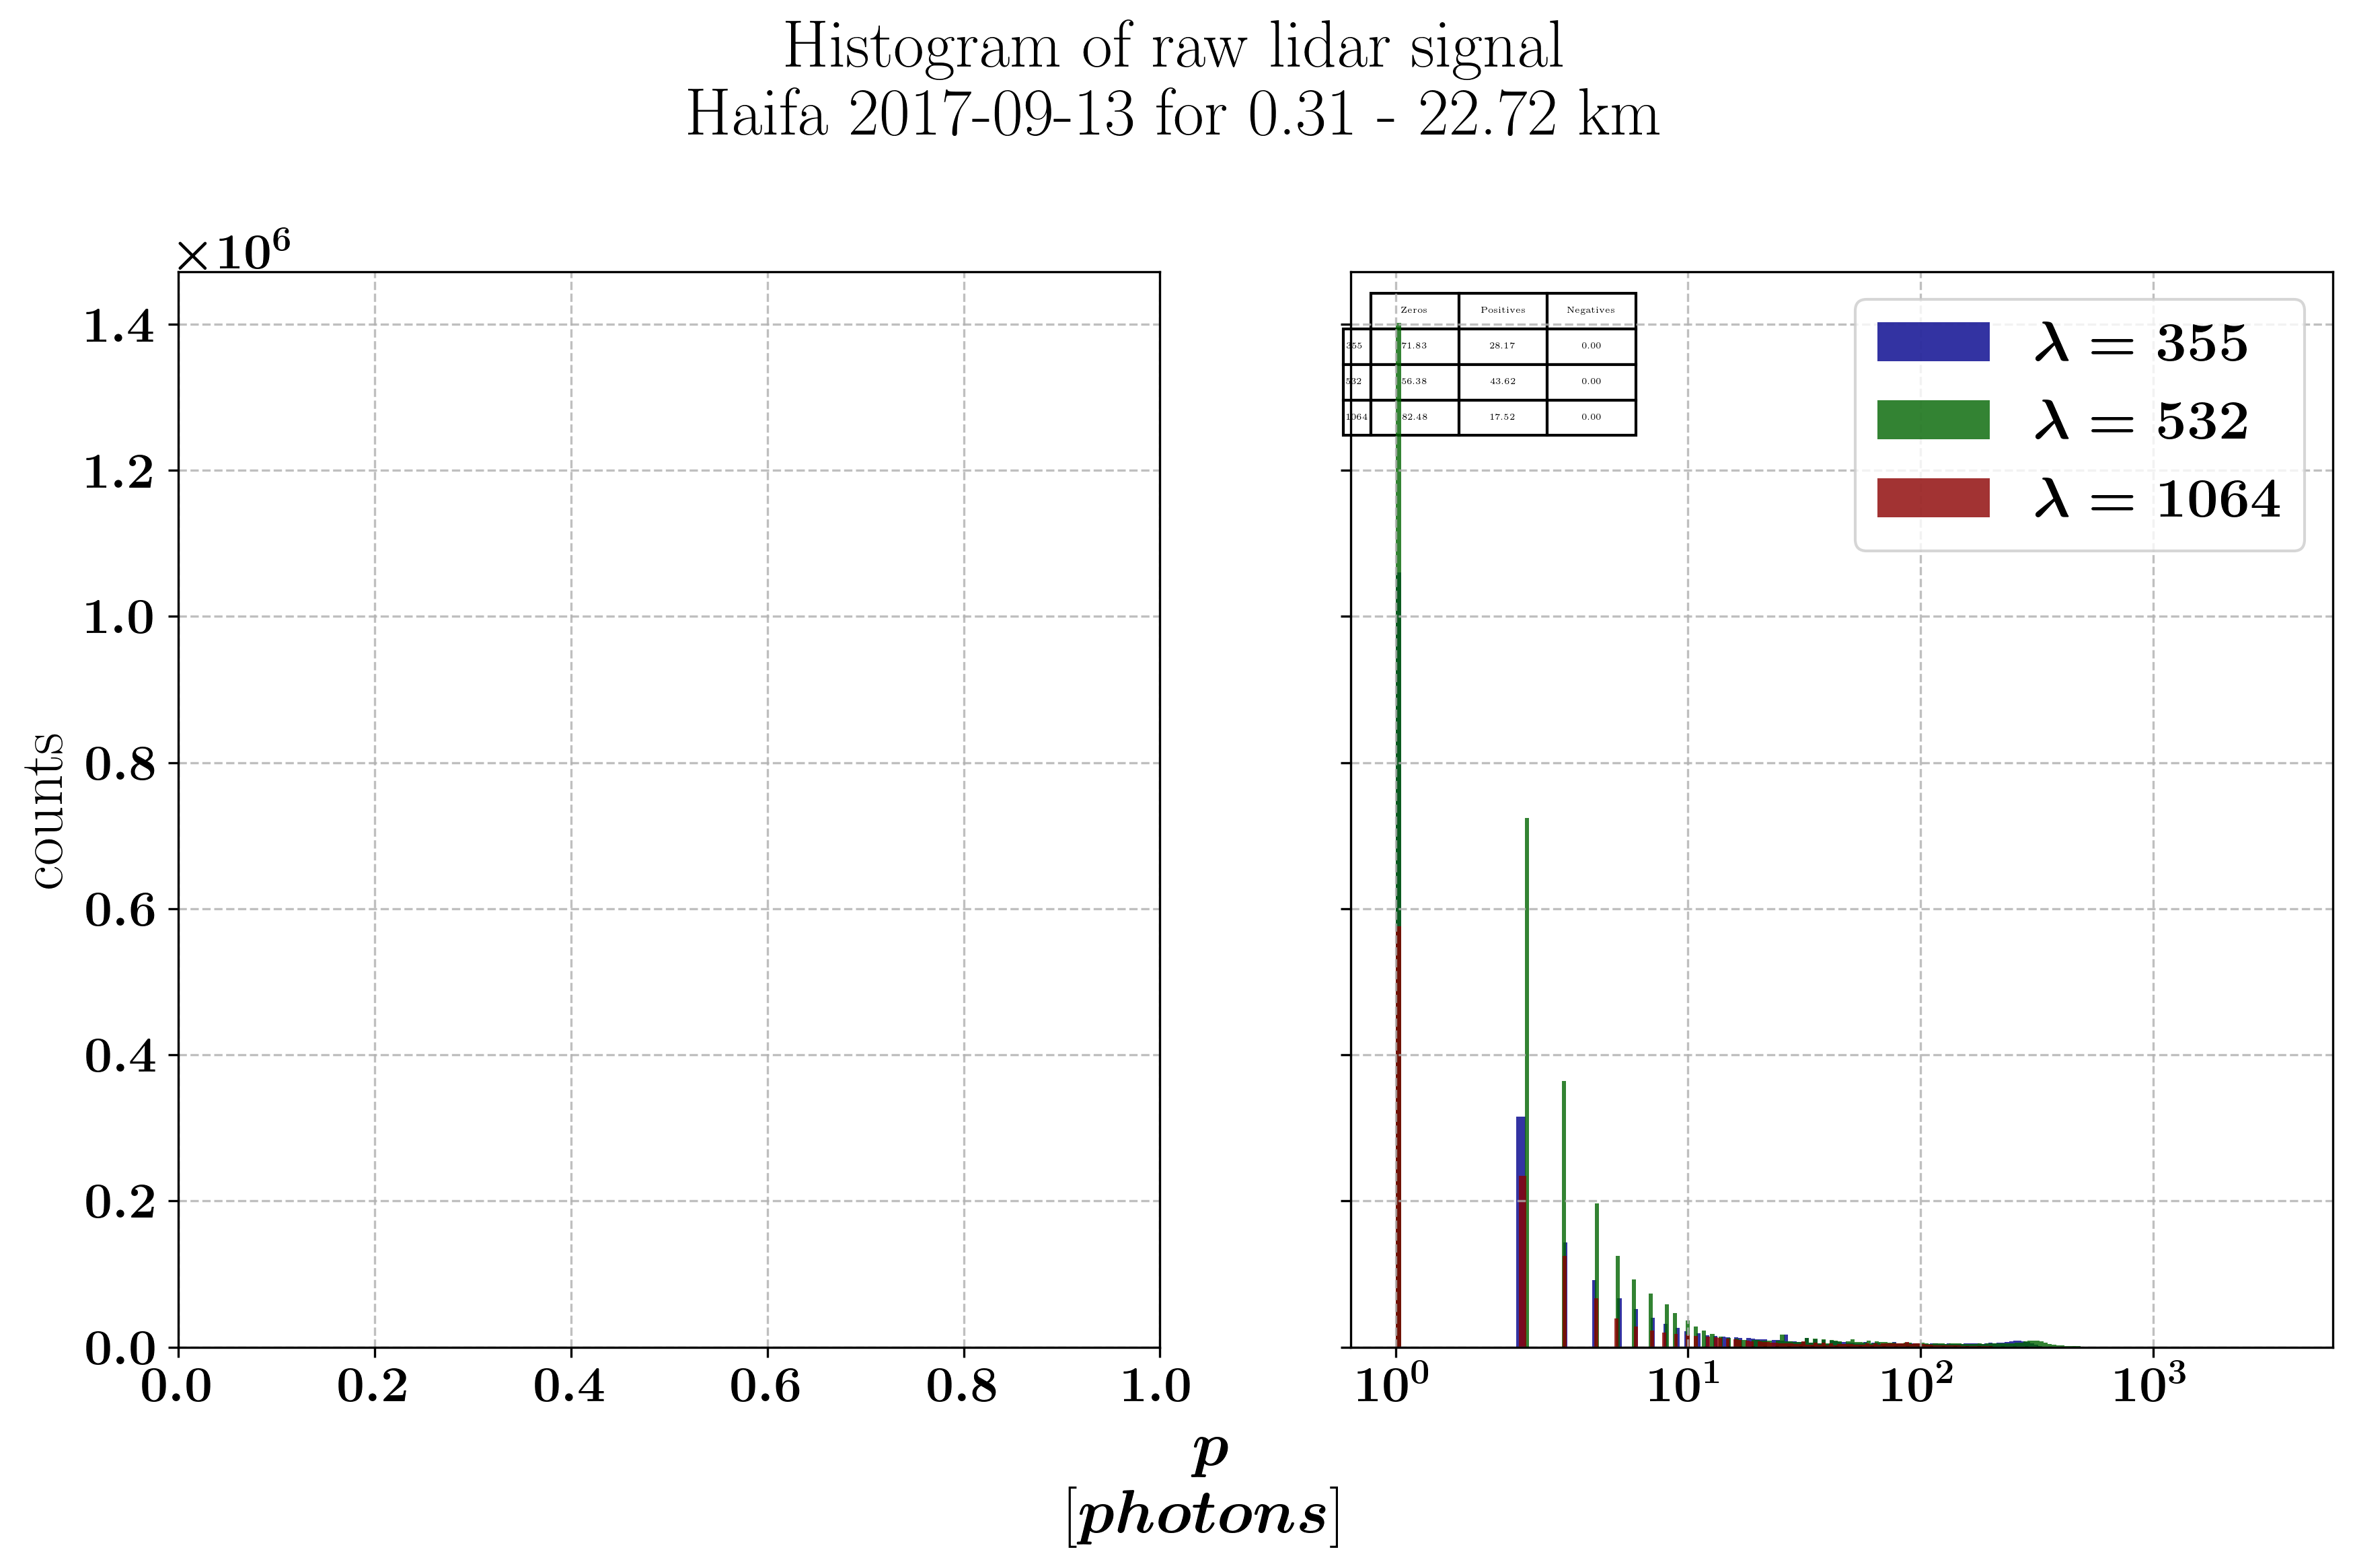

stats
Wavelength Stats          
355        zero      71.83
           positive  28.17
           negative   0.00
532        zero      56.38
           positive  43.62
           negative   0.00
1064       zero      82.48
           positive  17.52
           negative   0.00

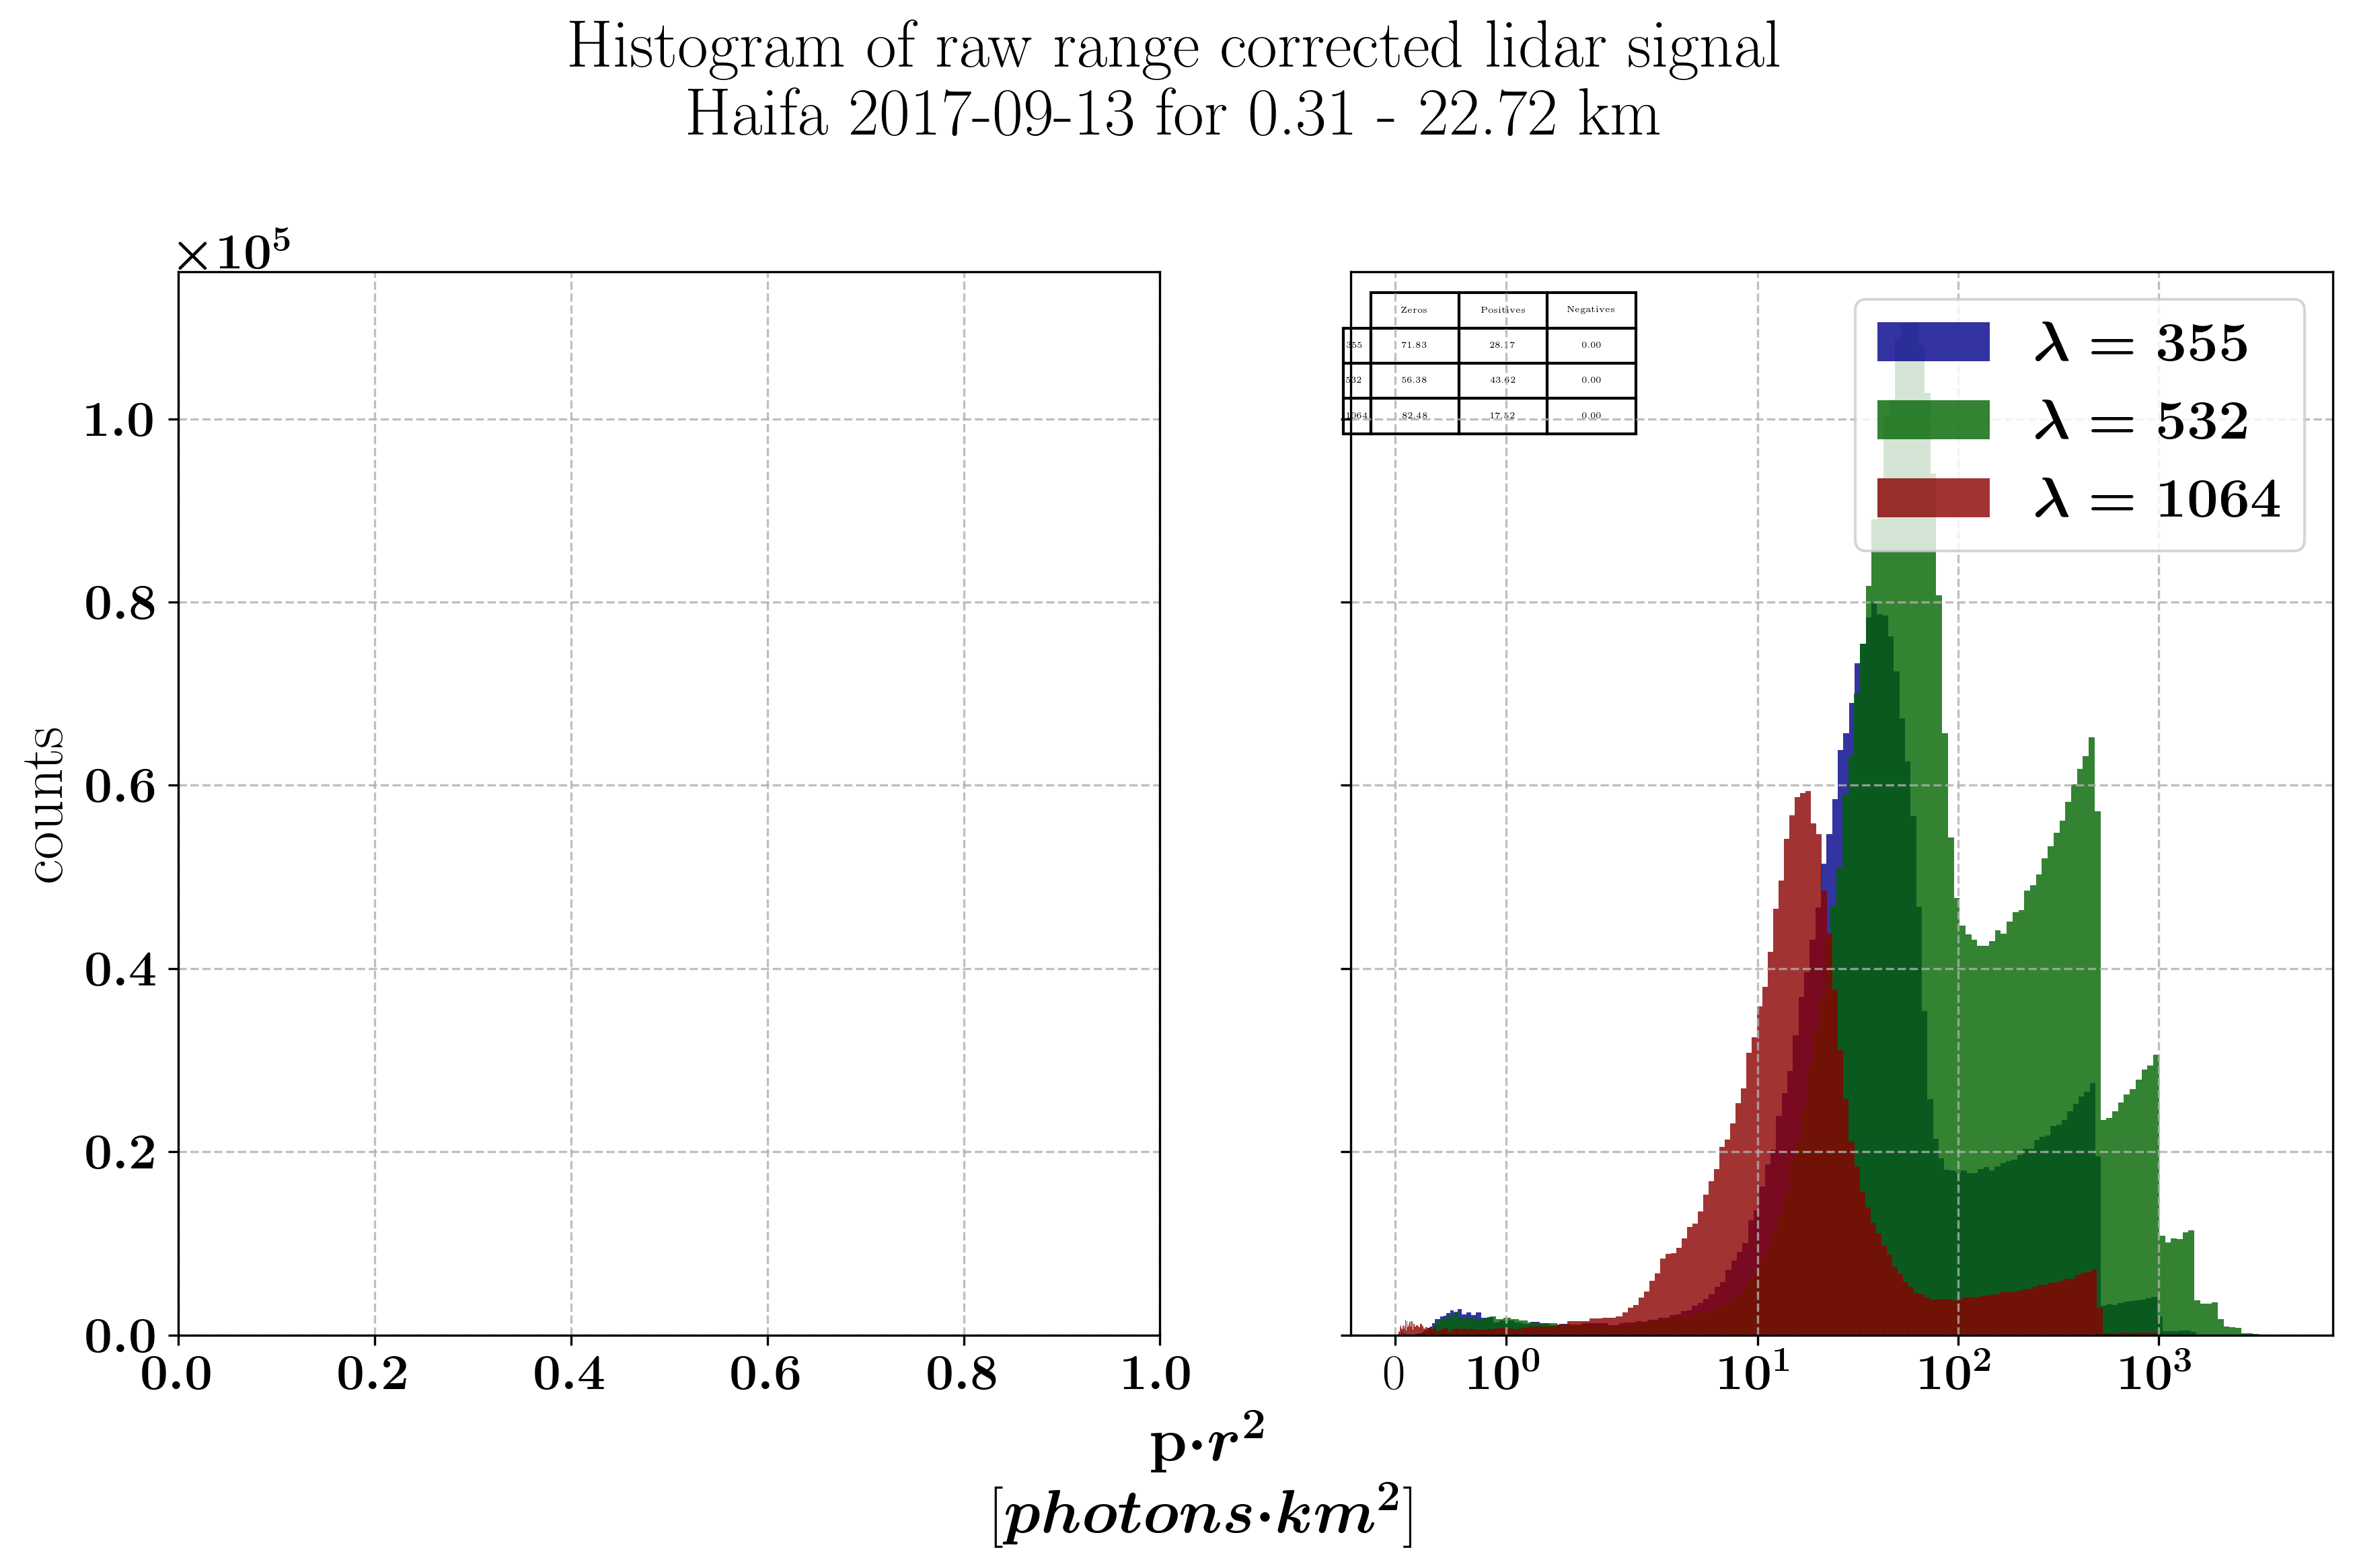

stats
Wavelength Stats          
355        zero      71.83
           positive  28.17
           negative   0.00
532        zero      56.38
           positive  43.62
           negative   0.00
1064       zero      82.48
           positive  17.52
           negative   0.00

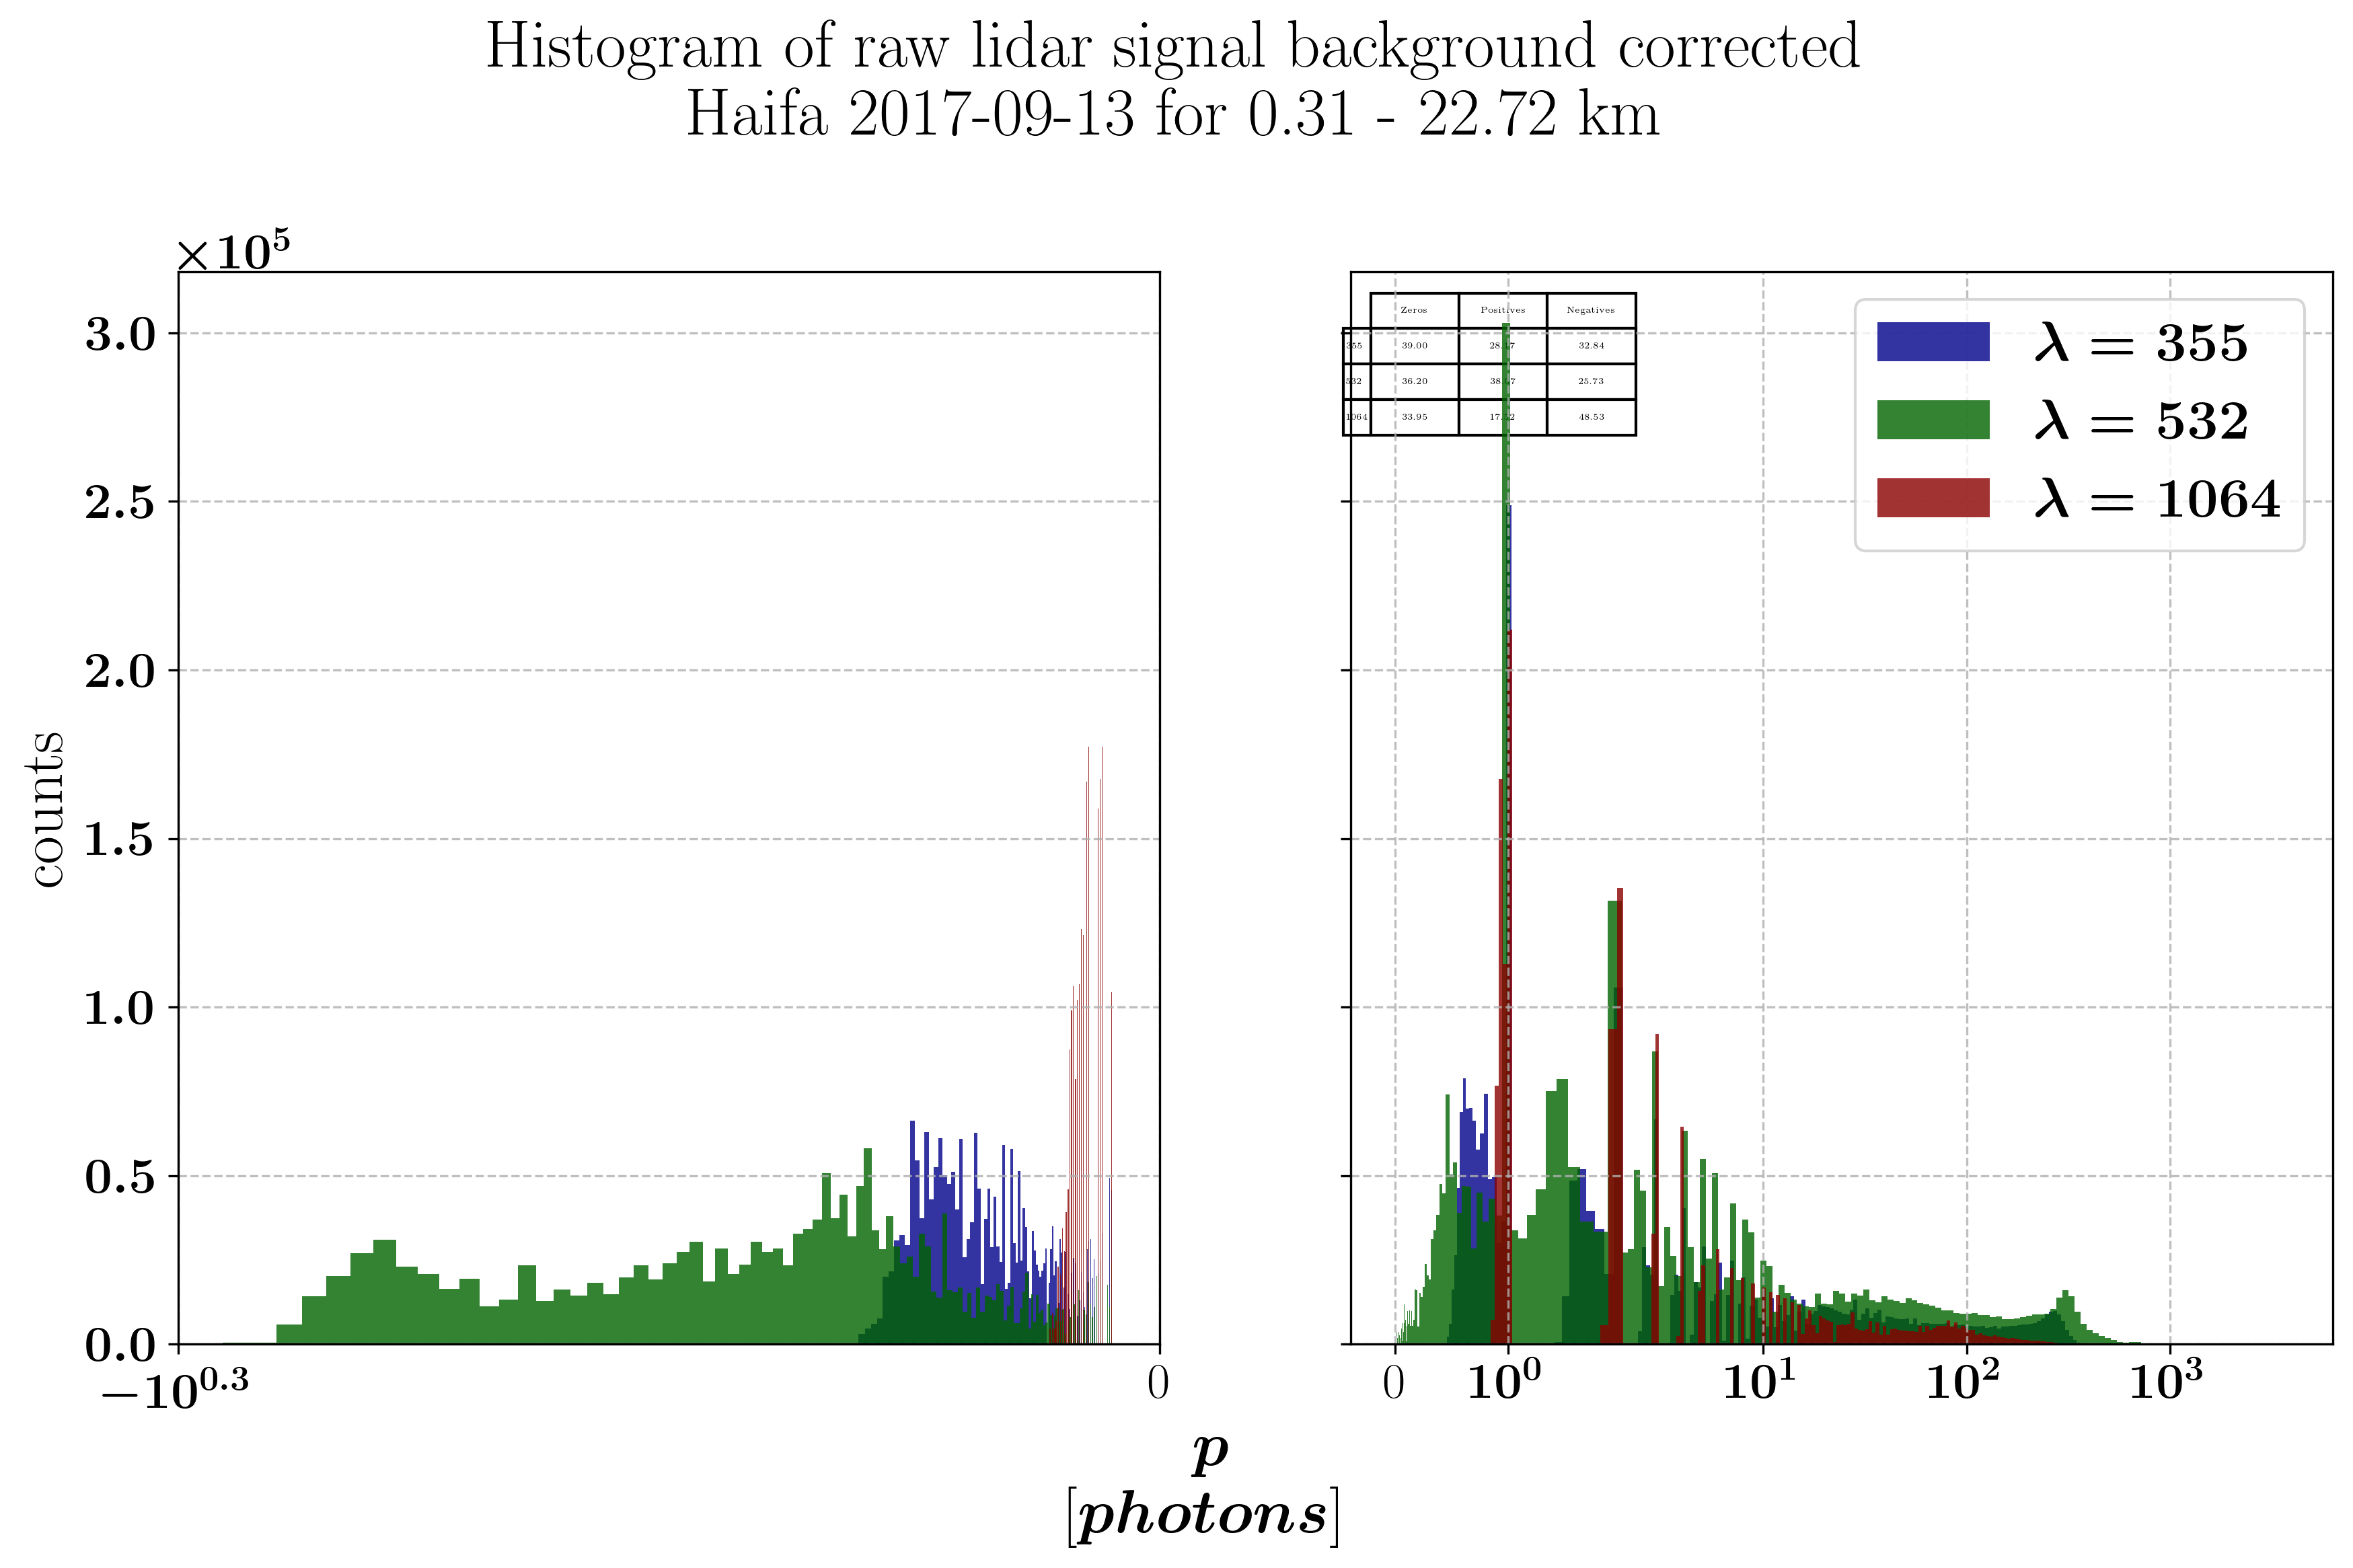

stats
Wavelength Stats          
355        zero      39.00
           positive  28.17
           negative  32.84
532        zero      36.20
           positive  38.07
           negative  25.73
1064       zero      33.95
           positive  17.52
           negative  48.53

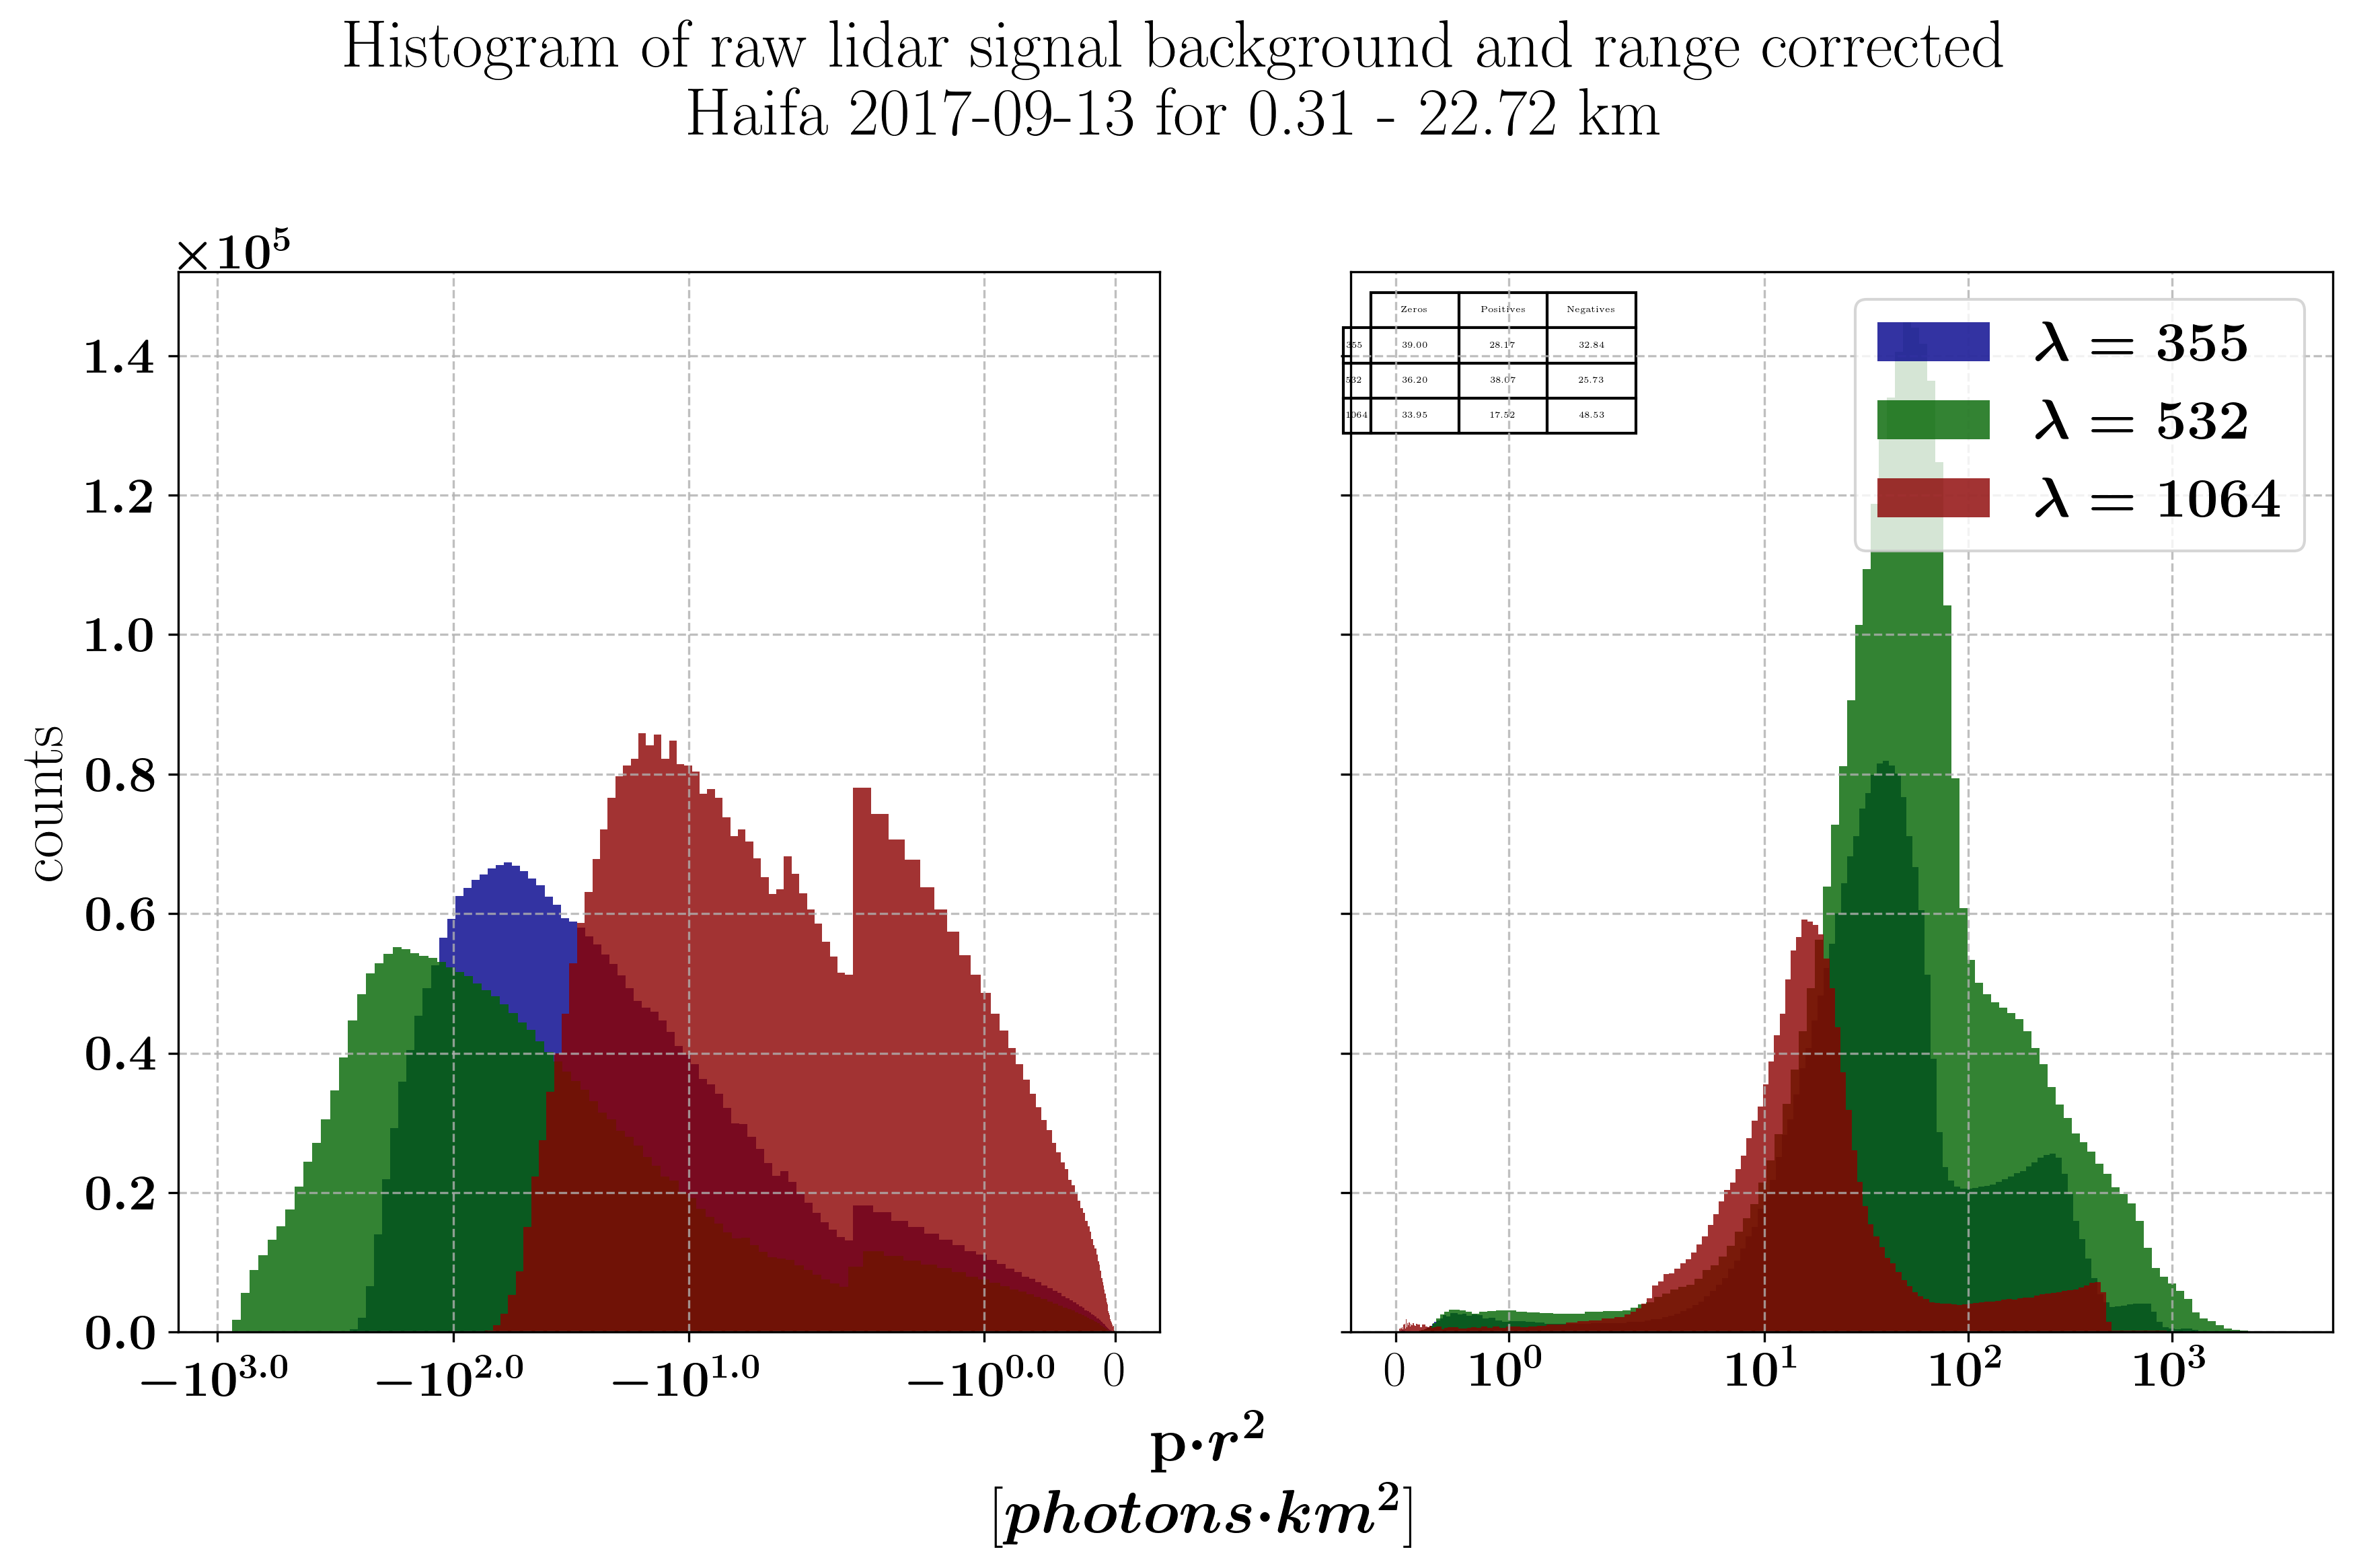

stats
Wavelength Stats          
355        zero      39.00
           positive  28.17
           negative  32.84
532        zero      36.20
           positive  38.07
           negative  25.73
1064       zero      33.95
           positive  17.52
           negative  48.53

In [6]:
h_ranges = [slice(0,23)]#,slice(0,3),slice(3,6),slice(6,9),slice(9,12),slice(12,15),slice(15,18),slice(18,21)]
for profile_type in ['p', 'range_corr','pBGC','pRBGC']:
	for h_range in h_ranges:
		fig, axes, ds_stats, fpath = vis_utils.daily_ds_histogram(ds_lidar, figsize=(12, 8),alpha=.8,
																  profile_type=profile_type,n_temporal_splits=1,height_range=h_range,SAVE_FIG = True,nbins=200,format_fig='svg')
		display(ds_stats[0].stats.to_dataframe())

In [14]:

fig, axes, ds_stats, fpath = vis_utils.daily_ds_histogram(ds_lidar, profile_type='pRBGC',n_temporal_splits=6,SAVE_FIG = False,nbins=200, format_fig='svg')

In [ ]:
raw_nc_paths = sorted(glob.glob(os.path.join(netcdf_folder,"*.nc")))
timestamps = [get_TROPOS_raw_nc_timestamp(path) for path in raw_nc_paths]
print(timestamps)
df_times = pd.DataFrame(data = timestamps, columns = ['timestamp'])

days_g = df_times.groupby([df_times.timestamp.dt.date]).groups
days = list(days_g.keys())
#print(days)

for day in days[1:2]:
	dt_day = datetime.combine(date = day, time =  time.min)
	dstamps = [timestamps[ind] for ind in days_g[day].tolist()]
	print(f'day: {day}, hours:{dstamps}')
	ds_hours = []
	for stamp in dstamps:
		filename = f"{stamp.strftime('%Y_%m_%d')}_{stamp.strftime('%a')}_TROPOS_{stamp.strftime('%H_%M')}_01.nc"
		lidar_ds = xr_utils.load_dataset(os.path.join(netcdf_folder,filename))
		print(filename)
		#print()
		#display(lidar_ds)

		channels =  gs.CHANNELS().get_elastic()
		wavelengths = gs.LAMBDA_nm().get_elastic()
		ds_chans = []

		# Separate bins to:
		# 1. background bins (pre-triggered)
		# 2. height bins of the raw signal (post-triggered)
		total_bins = lidar_ds.height.shape[0]
		pt_bin = 248 # pre-triggered bins
		height_bins = lidar_ds.height.values[pt_bin:total_bins]
		bg_bins = lidar_ds.height.values[0:pt_bin]
		n_heights =  height_bins.shape[0] # This value is useful for estimation of background signal from poisson distribution.

		# Calculate range and range^2
		height_res = lidar_ds.measurement_height_resolution.values * 1e-9
		range = np.array([(h_ind+1) * (gs.C_m_s*height_res)/2 for h_ind in (height_bins-pt_bin)])
		r2 = range**2  # this value is used to calculate range corrected signal: pr^2


		# Set height indexes
		altitude = lidar_ds.location_height.values
		range_km  = (range + altitude)* 1e-3

		# Set time indexes
		end_time = stamp + timedelta(hours=6) - timedelta(seconds = 30)
		times = pd.date_range(start =stamp,end = end_time, freq = '30S')

		# get raw signal per channel
		for chan,lambda_nm in zip(channels, wavelengths):
			df_bg = lidar_ds.sel(channel = chan , height = bg_bins).raw_signal.transpose(transpose_coords = True).to_pandas()
			df_raw = lidar_ds.sel(channel = chan, height = height_bins).raw_signal.transpose(transpose_coords = True).to_pandas()

			# calculate background signal
			df_mean_bg = df_bg.mean(axis=0)
			# bg_df = pd.DataFrame(np.array([misc_lidar.generate_poisson_signal(mu= mu_k,n= n_heights) for mu_k in mean_bg]).astype(np.int).T)

			# remove bg signal
			df_signal = df_raw - df_mean_bg
			#df_signal[df_signal<0]=0

			#calc range corrected signal
			df_pr2 = df_signal.apply(lambda row,r2: row*r2, axis=0,args = (r2,), result_type ='expand')
			#display(df_pr2)


			ds_chan= xr.Dataset (
			        data_vars = {'range_corr' : (('Height' , 'Time') , df_pr2    ),
			                     'bg_mean'    : (('Time')            , df_mean_bg),
			                     'raw_signal' : (('Height' , 'Time') , df_raw    ),
			                     'lambda_nm'  : ('Wavelength'        , [ lambda_nm ]   )
			                     } ,
			        coords = {'Height' : range_km ,
			                  'Time' : times.values,
							  'Wavelength' : [ lambda_nm ]})
			ds_chan.range_corr.attrs = {'long_name' : r'$p r^2$' ,
			                                       'units' : r'$photons \cdot m^2$' ,
			                                       'info' : 'Range corrected from raw lidar signal'}
			ds_chan.bg_mean.attrs = {'long_name' : r'$<p_{bg}>$' ,
			                                       'units' : r'$photons$' ,
			                                       'info' : 'Mean background from raw lidar signal'}
			ds_chan.raw_signal.attrs = {'long_name' : r'$p$' ,
			                                       'units' : r'$photons$' ,
			                                       'info' : 'Raw lidar signal'}
			# set attributes of coordinates
			ds_chan.Height.attrs = {'units' : '{}'.format ( '{}'.format ( 'km' ) ) ,
			                     'info' : 'Measurements heights above ground level'}
			ds_chan.Wavelength.attrs = {'long_name' : r'$\lambda$' , 'units' : r'$nm$'}

			ds_chans.append(ds_chan)

		cur_ds = xr.concat ( ds_chans , dim = 'Wavelength' )
		ds_hours.append(cur_ds)

ds_lidar_daily = xr.merge ( ds_hours , compat = 'no_conflicts' )
#display(ds_lidar_daily)

# Fixing missing timestamps values:
time_indx = pd.date_range(start = dt_day, end = (dt_day+timedelta(hours = 24)-timedelta(seconds = 30)), freq = '30S')
ds_lidar_daily = ds_lidar_daily.reindex ( {"Time" : time_indx} , fill_value = 0 )
# Adding info attributes:
ds_lidar_daily [ 'date' ] = dt_day
ds_lidar_daily.attrs [ 'location' ] = station.location
ds_lidar_daily.attrs [ 'info' ] = 'Daily measured lidar signals'
ds_lidar_daily.attrs ['source_type'] = 'raw'
display(ds_lidar_daily)

In [ ]:
top_h =ds_lidar_daily.Height[3000].values.tolist()
min_h = ds_lidar_daily.Height[0].values.tolist()

topCL_h_gnd = 15.0 + altitude * 1e-3 # km
micCL_h_gnd = 0.0 + altitude * 1e-3
topCL_h = ds_lidar_daily.Height[np.abs(ds_lidar_daily.Height.values - topCL_h_gnd).argmin()].values
minCL_h = ds_lidar_daily.Height[np.abs(ds_lidar_daily.Height.values - micCL_h_gnd).argmin()].values
print(f'calibration range: [{minCL_h:.2f},{topCL_h:.2f}] [km] - above sea level')

In [ ]:
SAVE_FIG = False
lambda_nm=532
g1 = vis_utils.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)), lambda_nm,
		                                   profile_type = 'range_corr', SAVE_FIG= SAVE_FIG)
for lambda_nm in wavelengths:
	g2 = vis_utils.visualize_ds_profile_chan(ds_lidar_daily, lambda_nm = lambda_nm,
	                                    profile_type = 'bg_mean', SAVE_FIG= SAVE_FIG)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
ds_lidar_daily.bg_mean.plot(hue = 'Wavelength',ax=ax)
ax.xaxis.set_major_formatter(gs.TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
plt.title(ds_lidar_daily.bg_mean.attrs['info'])
plt.show()

In [ ]:
maxbg_g = ds_lidar_daily.bg_mean.sel(Wavelength=532).max().item()
maxbg_ir = ds_lidar_daily.bg_mean.sel(Wavelength=1064).max().item()
maxbg_b = ds_lidar_daily.bg_mean.sel(Wavelength=355).max().item()
(maxbg_g,maxbg_ir,maxbg_b)
(maxbg_g,maxbg_g/maxbg_ir,maxbg_g/maxbg_b)

In [ ]:
g3 = vis_utils.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                               lambda_nm = lambda_nm,profile_type = 'raw_signal',SAVE_FIG= SAVE_FIG)

for wav in wavelengths:
	g = vis_utils.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)), lambda_nm,
		                                   profile_type = 'range_corr', SAVE_FIG= SAVE_FIG, USE_RANGE='LOW')

In [ ]:
_,_,df_stats = vis_utils.daily_ds_histogram(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                                  profile_type='raw_signal', SAVE_FIG = SAVE_FIG)
display(df_stats)

_,_,df_stats = vis_utils.daily_ds_histogram(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                                  profile_type='range_corr', SAVE_FIG = SAVE_FIG)
display(df_stats)


In [ ]:
from scipy.stats import poisson

mus = np.arange(0,6.5,0.5)
mus = np.sort(np.append(mus,[0.1,0.2,50,1000]))
df_stats = pd.DataFrame(columns=['mu', 'A', 'B', 'P(A)', 'P(B)','P(C)',
								 'P(D)','P(A|D)','P(C|D)','P(A|D)+P(C|D)'])
for  ind,(mu) in enumerate(mus):
	mu_f = np.floor(mu)
	t = mu_f if mu_f<mu else mu_f-1
	A= np.arange(start=0,stop=t+1).astype(int)
	B = int(mu_f) if not (int(mu_f) in A) else []
	#print('mu=',mu ,', A=',A,' B=',B)
	sum_pmf = 0
	for x_i in A:
		pmf_i = poisson.pmf(x_i, mu)
		sum_pmf+=pmf_i
	P_A = sum_pmf
	P_B = poisson.pmf(B, mu) if not (B==[]) else 0
	P_C = 1 - (P_A+P_B)
	P_D = 1-P_B
	P_A_D = P_A/P_D if P_D>0 else 0
	P_C_D = P_C/P_D if P_D>0 else 0
	df_stats.loc[ind] = [mu, A,B,f"{P_A:.4f}",f"{P_B:.4f}",
						 f"{P_C:.4f}",f"{P_D:.4f}",
						 f"{P_A_D:.4f}",f"{P_C_D:.4f}",f"{P_A_D+P_C_D:.2f}"]

	#print('P(A)=', P_A,', P(B)=',P_B,', P(C)=',P_C,', P(D)=',P_D)
	#print('P(A|D)=',P_A_D,', P(C|D)=',P_C_D,', P(A|D)+P(C|D) =',P_A_D+P_C_D)

In [ ]:
df_stats